In [1]:
# # 초기 1회 실행
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# 📥 데이터 다운로드 (Download Dataset)
# GitHub에서 csv 파일을 다운로드합니다.

!wget https://raw.githubusercontent.com/Dropthe-bit/ai_portfolio/main/data/HR_nona.csv

--2025-06-27 13:01:09--  https://raw.githubusercontent.com/Dropthe-bit/ai_portfolio/main/data/HR_nona.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 566007 (553K) [text/plain]
Saving to: ‘HR_nona.csv’

HR_nona.csv         100%[===================>] 552.74K  --.-KB/s    in 0.04s   

2025-06-27 13:01:09 (13.1 MB/s) - ‘HR_nona.csv’ saved [566007/566007]



# Machine_Learning3_boosting

In [3]:
## 필요 패키지 설치 및 import
import importlib.util
import subprocess
import sys
def install_and_import(packages):
    for pkg in packages:
        package = pkg
        try:
            importlib.util.find_spec(package)
            print(f"{package} is already installed.")
        except ImportError:
            # 모듈이 설치되어 있지 않은 경우 설치시도
            print(f"{package} is not installed. Installing...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            subprocess.check_call(["conda", "install", package, "-y"])

            # 설치 후 다시 임포트를 시도
            importlib.import_module(package)
            print(f"{package} has been successfully installed.")

        # finally:
        #     globals()[package] = importlib.import_module(package)
        except Exception as e:
            # 설치 중 예외가 발생한 경우, 에러 메시지를 출력
            print(f"An error occurred while installing {package}: {str(e)}")

# 예시 사용법
install_and_import(['xgboost'])


xgboost is already installed.


In [4]:
## 필요 모듈 임포트
import os, sys, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report

# 데이터 읽기

## 데이터 읽기

In [5]:
## 데이터 로드
rd = pd.read_csv('HR_nona.csv')
rd = rd.dropna()
df = rd.copy()

df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales,salary,left
0,0.38,0.53,2,157,3,0,0,sales,low,1
1,0.80,0.86,5,262,6,0,0,sales,medium,1
2,0.11,0.88,7,272,4,0,0,sales,medium,1
3,0.72,0.87,5,223,5,0,0,sales,low,1
4,0.37,0.52,2,159,3,0,0,sales,low,1


In [6]:
## 범주형 변수로 변환
df['left'] = pd.Categorical(df['left'])

# df['time_spend_company'] = df['time_spend_company'].astype('category')
# df['number_project'] = df['number_project'].astype('category')
df['Work_accident'] = df['Work_accident'].astype('category')
df['promotion_last_5years'] = df['promotion_last_5years'].astype('category')
df['sales'] = df['sales'].astype('category')
df['salary'] = df['salary'].astype('category')

In [7]:
from sklearn.preprocessing import LabelEncoder

## 레이블 인코딩 (범주형 변수를 수치형으로 변환)
label_encoders = {}
for column in df.select_dtypes(['category']).columns:
    if column != 'left':  # 타겟 변수는 인코딩하지 않음
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

## 데이터셋 분할
X, y = df.drop('left', axis=1), df['left']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                                                                  test_size = 0.3,
                                                                                                  random_state = 123,
                                                                                                  stratify = y)  # y 변수를 기반으로 층화추출, df['left']를 써도 됨

## Adaboost

### Adaboost

In [10]:
from sklearn.ensemble import AdaBoostClassifier

## AdaBoost
ada = AdaBoostClassifier(
                                  estimator = DecisionTreeClassifier(max_depth = 1), # 약한 학습기로 깊이가 1인 의사결정나무 사용 (기본값은 DecisionTreeClassifier)
                                  n_estimators = 100,   # 100개의 약한 학습기 사용(default = 50)
                                  learning_rate = 0.1,  # 학습률
                                  random_state = 123    # 랜덤 시드 설정
)

## AdaBoost 모델 학습
ada.fit(X_train, y_train)


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.1, n_estimators=100, random_state=123)

In [11]:
from sklearn.metrics import confusion_matrix

def custom_confusion_matrix(y_true, y_pred):

        ## 혼동 행렬 계산
        cm = confusion_matrix(y_true=y_true,
                                                          y_pred=y_pred)
        ## 클래스 1을 기준으로 행과 열 순서 변경
        cm = cm[::-1, ::-1]

        ## 행과 열을 바꾸기 위해 전치(transpose)
        cm_transposed = cm.T
        print(cm_transposed)


        # DataFrame으로 변환 (라벨 추가)
        df_cm = pd.DataFrame(cm_transposed,
                                                      index = ['pred 1', 'pred 0'],
                                                      columns = ['act 1', 'act 0'])

        ## 히트맵 그리기
        plt.figure(figsize = (7,5))
        sns.heatmap(df_cm, annot = True, fmt = 'd', cmap = 'Blues')
        plt.title('Confusion Matrix (Class 1 as Positive)')
        plt.ylabel('Predicted')
        plt.xlabel('Actual')
        plt.show()

### 1차 예측 결과

[[ 716   43]
 [ 354 3381]]


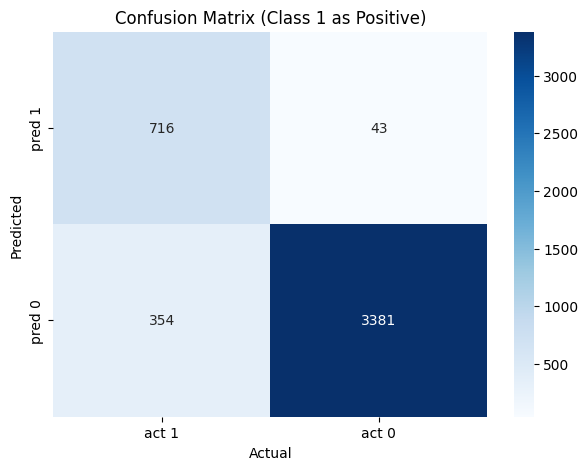

None


,0,1,accuracy,macro avg,weighted avg
precision,0.905221,0.943347,0.91166,0.924284,0.914298
recall,0.987442,0.669159,0.91166,0.828300,0.911660
f1-score,0.944545,0.782941,0.91166,0.863743,0.906068
support,3424.000000,1070.000000,0.91166,4494.000000,4494.000000


In [12]:
## 테스트 데이터에 대한 예측
y_pred_ada = ada.predict(X_test)


## 테스트 데이터에 대한 예측 확률
# y_pred_prob_ada = ada.predict_proba(X_test)


print(custom_confusion_matrix(y_test, y_pred_ada))
report = classification_report(y_test,
                                                             y_pred_ada,
                                                             digits = 4,
                                                             output_dict = True)
pd.DataFrame(report)

### 변수 중요도

In [13]:
## 변수 중요도 계산: 원래는 최적 파라미터를 찾은 다음에...
importance = pd.Series(ada.feature_importances_,
                                                 index = X_train.columns)

## 중요도 순서대로 정렬
importance_sorted = importance.sort_values(ascending = False)
importance_sorted

,0
satisfaction_level,0.520411
time_spend_company,0.261960
number_project,0.181014
last_evaluation,0.024849
average_montly_hours,0.011767
Work_accident,0.000000
promotion_last_5years,0.000000
sales,0.000000
salary,0.000000


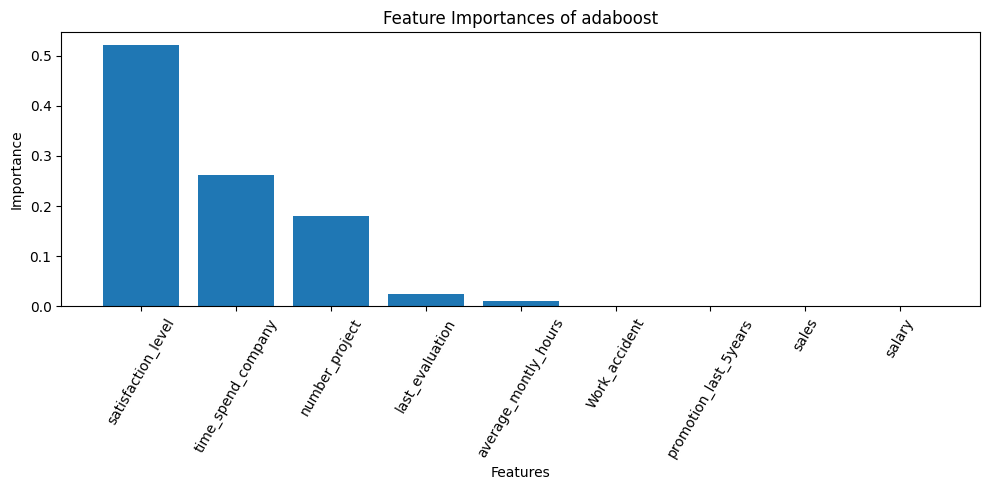

In [14]:
## 변수 중요도 시각화
plt.figure(figsize = (10, 5))
plt.title('Feature Importances of adaboost')
plt.bar(importance_sorted.index, importance_sorted.values)
plt.xticks(rotation=60)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

### 최적 파라미터 찾기

In [17]:
## GridSearchCV를 사용한 하이퍼파라미터 튜닝
param_grid = {
    'n_estimators': [50, 100], # 약한 학습기의 개수
    'learning_rate': [0.01, 0.1], # 학습률
    'estimator__max_depth': [1,  3] # 기본 학습기 의사결정나무의 최대 깊이
}

grid_search = GridSearchCV(estimator = AdaBoostClassifier(estimator = DecisionTreeClassifier( ),
                           random_state = 123),
                           param_grid = param_grid,
                           cv = 3, # 교차 검증 폴드 수
                           refit = True, # 교차 검증 후, 최적 값을 저장,
                           scoring = 'accuracy', # 평가 지표: 정확도,
                           verbose = 1,
                           n_jobs = -1) # 병렬 처리
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                          random_state=123),
             n_jobs=-1,
             param_grid={'estimator__max_depth': [1, 3],
                         'learning_rate': [0.01, 0.1],
                         'n_estimators': [50, 100]},
             scoring='accuracy', verbose=1)

In [18]:
## 최적의 하이퍼파라미터 출력
print("Best Hyperparameters: ", grid_search.best_params_)

# max_depth를 1이 아닌값으로 설정해도 여전히 AdaBoost 알고리즘...
#  다만, 전통적인 AdaBoost의 "매우 약한" 학습기 개념에서는 벗어나지만.. 실무에서는 사용해도 무방

Best Hyperparameters:  {'estimator__max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 100}


[[ 974   57]
 [  96 3367]]


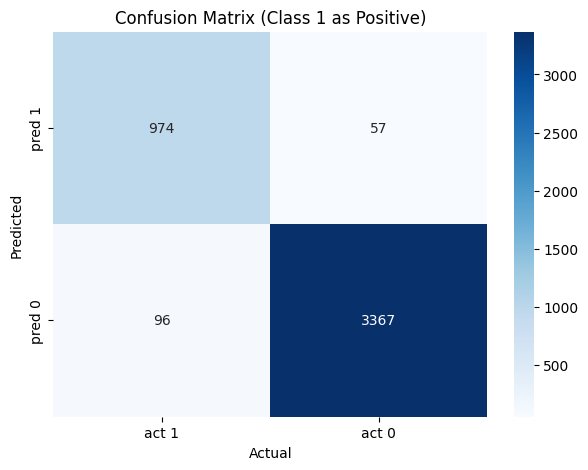

None


,0,1,accuracy,macro avg,weighted avg
precision,0.972278,0.944714,0.965955,0.958496,0.965715
recall,0.983353,0.910280,0.965955,0.946817,0.965955
f1-score,0.977784,0.927178,0.965955,0.952481,0.965735
support,3424.000000,1070.000000,0.965955,4494.000000,4494.000000


In [19]:
## 최적의 하이퍼파라미터로 재학습
# best_ada = grid_search.best_estimator_
# best_ada.fit(X_train, y_train)
best_ada = grid_search


## 최적의 모델로 테스트 데이터에 대한 예측
y_pred_ada = best_ada.predict(X_test)


## 최종 혼동 행렬 및 분류 보고서 출력
print(custom_confusion_matrix(y_test, y_pred_ada))
report = classification_report(y_test,
                                                             y_pred_ada,
                                                             digits = 4,
                                                             output_dict = True)
pd.DataFrame(report)

In [20]:
## 클래스별 F1 Score
f1_score_class_0 = report['0']['f1-score']
f1_score_class_1 = report['1']['f1-score']


## 전체 평균 F1 Score
f1_score_macro_avg = report['macro avg']['f1-score']
f1_score_weighted_avg_ada = report['weighted avg']['f1-score'] # 좀 더 일반적


## 최적 모델 정확도
accuracy_ada = report['accuracy']
accuracy_ada

0.9659546061415221

## GBM

### Gradient Boosting Machine

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

## GBM 분류기 정의
gbm = GradientBoostingClassifier(
                                                loss = 'log_loss',            # 손실 함수: 로그 손실(분류)
                                                learning_rate = 0.1,          # 러닝 레이트(default  0.1)
                                                n_estimators = 100,           # 약한 학습기의 개수
                                                max_depth = 3,                # 트리의 최대 깊이(default 3)
                                                random_state = 123            # 랜덤 시드
                                                )

## GBM 모델 학습
gbm.fit(X_train, y_train)



GradientBoostingClassifier(random_state=123)

In [22]:
# ## 참고: 회귀 GBM
# from sklearn.ensemble import GradientBoostingRegressor

# # 회귀 모델 정의
# gbr = GradientBoostingRegressor(
#     loss = 'squared_error',      # 회귀용 손실 함수: 평균 제곱 오차
#     learning_rate = 0.1,         # 학습률
#     n_estimators = 100,          # 약한 학습기의 개수
#     max_depth = 3,               # 트리의 최대 깊이
#     random_state = 123           # 랜덤 시드
# )

# # 모델 학습
# gbr.fit(X_train, y_train)


### 1차 예측 결과

[[ 991   36]
 [  79 3388]]


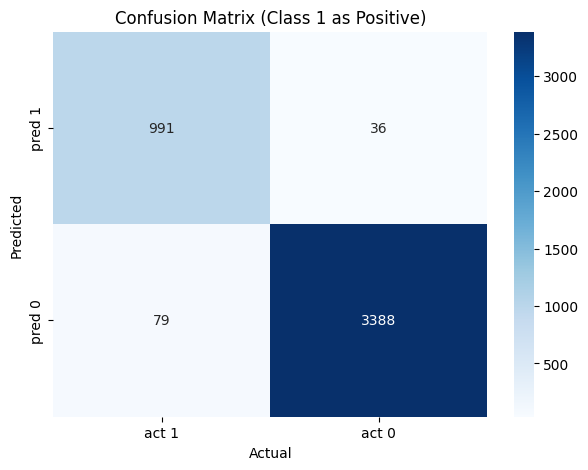

None


,0,1,accuracy,macro avg,weighted avg
precision,0.977214,0.964946,0.97441,0.971080,0.974293
recall,0.989486,0.926168,0.97441,0.957827,0.974410
f1-score,0.983312,0.945160,0.97441,0.964236,0.974228
support,3424.000000,1070.000000,0.97441,4494.000000,4494.000000


In [23]:
# 테스트 데이터에 대한 예측
y_pred_gbm = gbm.predict(X_test)


# 혼동 행렬 및 분류 보고서 출력
y_pred_prob_gbm = gbm.predict_proba(X_test)

print(custom_confusion_matrix(y_test, y_pred_gbm))
report = classification_report(y_test,
                                                             y_pred_gbm,
                                                             digits = 4,
                                                             output_dict = True)
pd.DataFrame(report)


### 변수 중요도

In [24]:
## 변수 중요도 계산: 원래는 최적 파라미터를 찾은 다음에...
importance = pd.Series(gbm.feature_importances_, index=X_train.columns)

## 중요도 순서대로 정렬
importance_sorted = importance.sort_values(ascending = False)
importance_sorted


,0
satisfaction_level,0.545405
time_spend_company,0.168811
number_project,0.110222
last_evaluation,0.101274
average_montly_hours,0.071333
salary,0.001246
Work_accident,0.001170
sales,0.000538
promotion_last_5years,0.000000


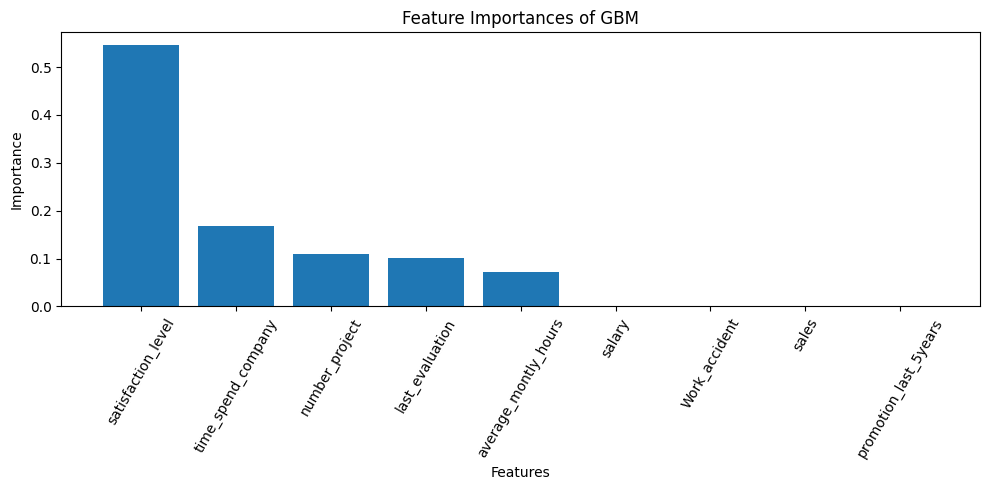

In [25]:
## 변수 중요도 시각화
plt.figure(figsize=(10, 5))
plt.title('Feature Importances of GBM')
plt.bar(importance_sorted.index, importance_sorted.values)
plt.xticks(rotation=60)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

### 최적 파라미터 찾기

In [26]:
# GridSearchCV를 사용한 하이퍼파라미터 튜닝
param_grid = {
                                'n_estimators': [50, 100, ],   # 약한 학습기의 개수
                                'learning_rate': [0.01, 0.1], # 학습률 # 보통 0.01 ~ 0.1 사이
                                'max_depth': [2, 3, 4]           # 트리의 최대 깊이
}

grid_search = GridSearchCV(estimator = GradientBoostingClassifier(random_state = 123),
                                                            param_grid = param_grid,
                                                            cv = 3,                 # 교차 검증 폴드 수
                                                            refit = True,      # 교차 검증 후, 최적 값을 저장
                                                            scoring = 'accuracy',  # 평가 지표: 정확도
                                                            n_jobs = -1)                   # 병렬 처리

grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print(f"Best Hyperparameters: {grid_search.best_params_}")

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


[[1005   27]
 [  65 3397]]


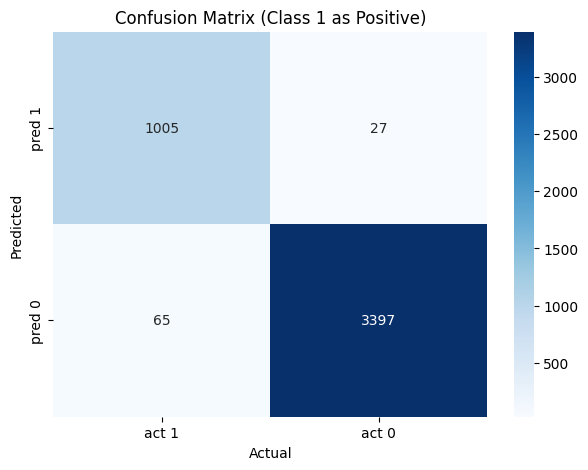

None


,0,1,accuracy,macro avg,weighted avg
precision,0.981225,0.973837,0.979528,0.977531,0.979466
recall,0.992114,0.939252,0.979528,0.965683,0.979528
f1-score,0.986640,0.956232,0.979528,0.971436,0.979400
support,3424.000000,1070.000000,0.979528,4494.000000,4494.000000


In [27]:
## 최적의 하이퍼파라미터로 재학습
# best_gbm = grid_search.best_estimator_
# best_gbm.fit(X_train, y_train)
best_gbm = grid_search


## 최적의 모델로 테스트 데이터에 대한 예측
y_pred_gbm = best_gbm.predict(X_test)


## 최종 혼동 행렬 및 분류 보고서 출력
print(custom_confusion_matrix(y_test, y_pred_gbm))
report = classification_report(y_test, y_pred_gbm, digits = 4,  output_dict=True)
pd.DataFrame(report)

In [28]:
## 클래스별 F1 Score
f1_score_class_0 = report['0']['f1-score']
f1_score_class_1 = report['1']['f1-score']


## 전체 평균 F1 Score
f1_score_macro_avg = report['macro avg']['f1-score']
f1_score_weighted_avg_gbm = report['weighted avg']['f1-score']


## 정확도
accuracy_gbm = report['accuracy']
accuracy_gbm

0.9795282599020917

## 비교

In [29]:
## 결과 비교
comparison_df = pd.DataFrame({
                                        'Model': ['Adaboost', 'GBM'],
                                        'Accuracy': [accuracy_ada,
                                                                 accuracy_gbm],
                                        'f1-score': [f1_score_weighted_avg_ada,
                                                               f1_score_weighted_avg_gbm]
})
comparison_df

,Model,Accuracy,f1-score
0,Adaboost,0.965955,0.965735
1,GBM,0.979528,0.979400


## XGB

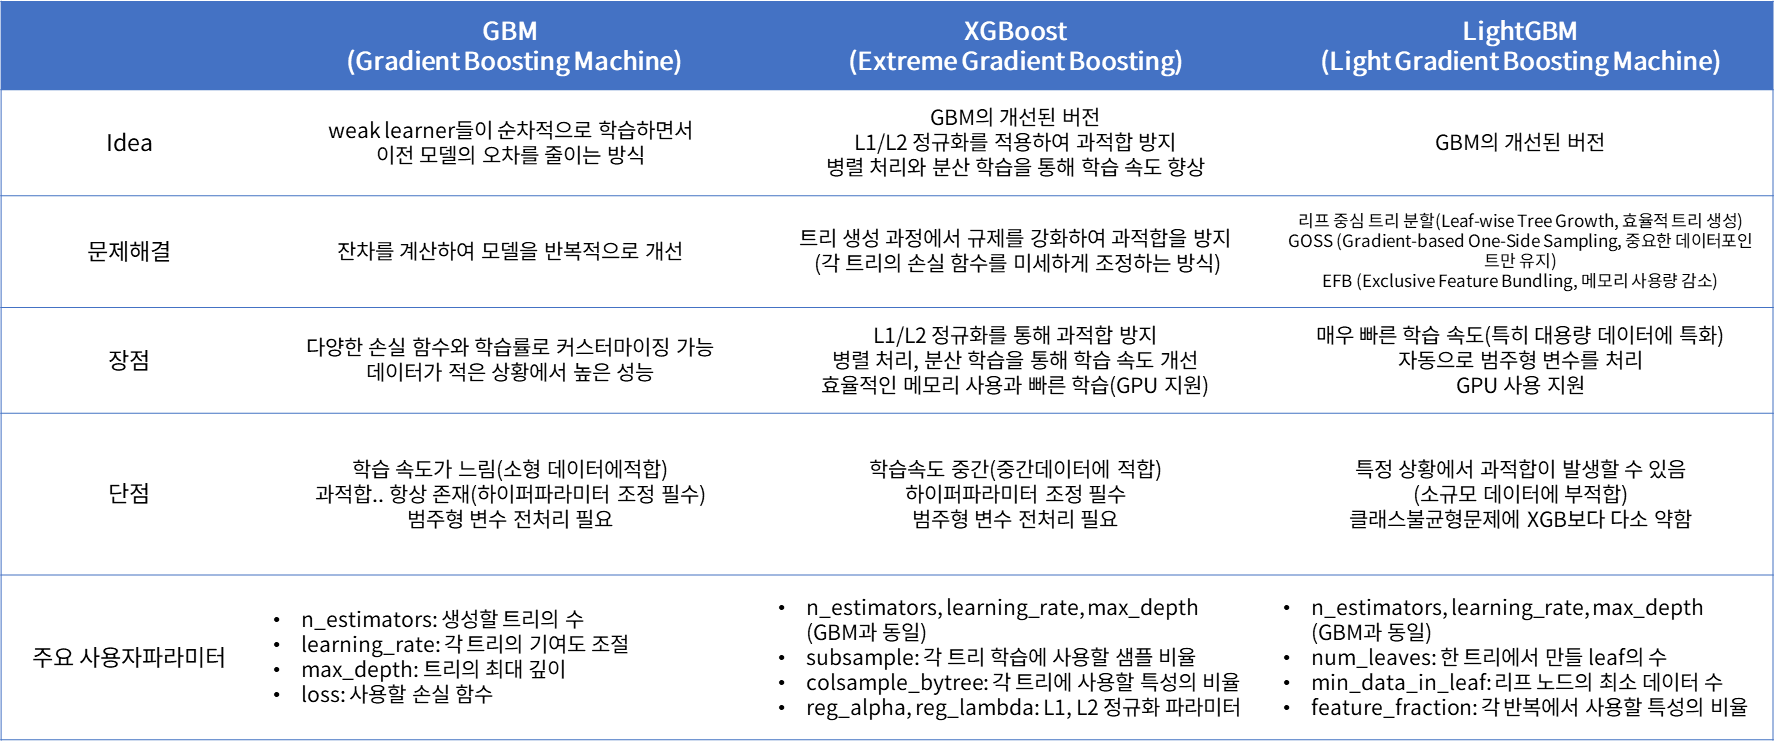

### eXtrem Grandient Boosting

In [30]:
# !pip install xgboost
from xgboost import XGBClassifier


In [31]:
## XGBoost 분류기 정의
xgb = XGBClassifier(
                                    objective = 'binary:logistic', # 이진 분류를 위한 목적 함수, 다진분류:  'multi:softprob' 사용
                                    learning_rate = 0.1,           # 러닝레이트(기본값은 0.3)
                                    n_estimators = 100,          # 약한 학습기의 개수
                                    max_depth = 3,                   # 트리의 최대 깊이(기본값은 6)
                                    eval_metric = 'logloss',        # 평가 지표: 로그 손실
                                    # min_child_weight = 1,  # 리프 노드를 만드는데 필요한 최소 가중치 합
                                    # subsample = 1,                 # 각 트리마다 사용할 훈련 데이터 샘플링 비율
                                    # colsample_bytree = 1,   # 각 트리 구성 시 사용할 피처 비율
                                    # colsample_bylevel = 1,  # 각 트리의 레벨별로 사용할 피처 비율
                                    # gamma = 0,                     # 리프 노드를 추가적으로 나눌지 결정하는 최소 손실 감소값
                                    # reg_alpha = 0,                # L1 정규화 강도
                                    # reg_lambda = 1,            # L2 정규화 강도
                                    random_state = 123,   # 랜덤 시드
                                )

## XGBoost 모델 학습
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=123, ...)

In [32]:
# from xgboost import XGBRegressor
## XGB 회귀 모델
# xgb_regressor_default_params = XGBRegressor(
#                                     learning_rate = 0.1,           # 러닝레이트(기본값은 0.3)
#                                     n_estimators = 100,          # 약한 학습기의 개수
#                                     max_depth = 3,                   # 트리의 최대 깊이(기본값은 6)
#                                     eval_metric = 'logloss',        # 평가 지표: 로그 손실
#                                     objective='reg:squarederror',  # 목적 함수 (회귀의 경우 기본값임)
# )

### 1차 예측 결과

In [33]:
## 테스트 데이터에 대한 예측
y_pred_xgb = xgb.predict(X_test)


## 테스트 데이터에 대한 예측 확률
# y_pred_prob_xgb = xgb.predict_proba(X_test)

[[ 984   40]
 [  86 3384]]


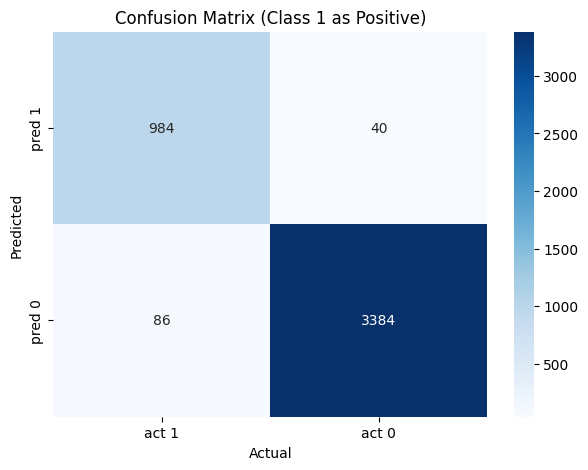

None


,0,1,accuracy,macro avg,weighted avg
precision,0.975216,0.960938,0.971963,0.968077,0.971816
recall,0.988318,0.919626,0.971963,0.953972,0.971963
f1-score,0.981723,0.939828,0.971963,0.960776,0.971748
support,3424.000000,1070.000000,0.971963,4494.000000,4494.000000


In [34]:
## 예측 결과
print(custom_confusion_matrix(y_test, y_pred_xgb))
report = classification_report(y_test, y_pred_xgb,
                                                              digits = 4,
                                                              output_dict=True)
pd.DataFrame(report)


### 변수 중요도

In [35]:
## 변수 중요도 계산: 원래는 최적 파라미터를 찾은 다음에...
importance = pd.Series(xgb.feature_importances_, index=X_train.columns)


# 중요도 순서대로 정렬
importance_sorted = importance.sort_values(ascending = False)
importance_sorted


,0
satisfaction_level,0.341971
time_spend_company,0.273456
number_project,0.126076
last_evaluation,0.103880
average_montly_hours,0.069757
Work_accident,0.041932
salary,0.029965
sales,0.012964
promotion_last_5years,0.000000


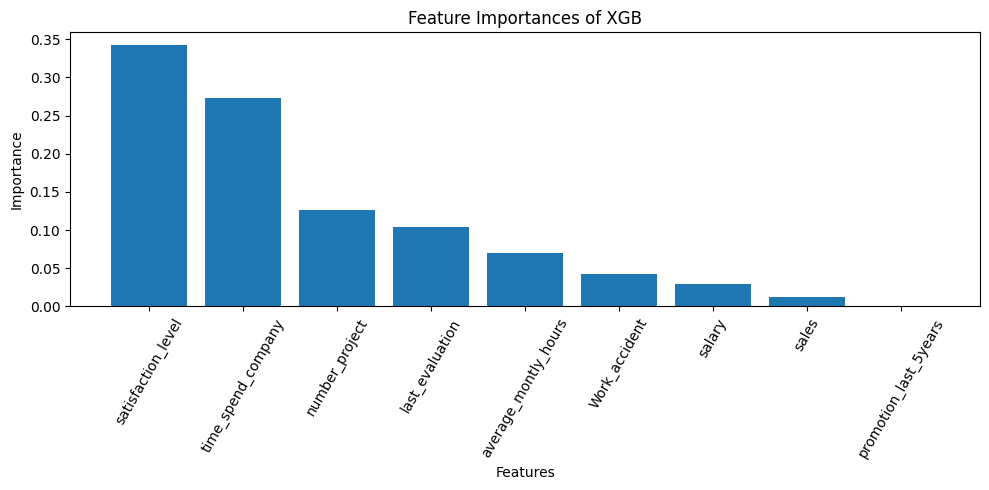

In [36]:
## 변수 중요도 시각화
plt.figure(figsize=(10, 5))
plt.title('Feature Importances of XGB')
plt.bar(importance_sorted.index, importance_sorted.values)
plt.xticks(rotation=60)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

### 최적 파라미터 찾기

- colsample_bytree:
  -  피처 샘플링 비율로, 각 트리를 구성할 때 피처를 무작위로 선택하여 학습하는 데 사용
  - 1 보다 작게 설정하면 다양한 피처 조합을 사용해 과적합 방지 효과

- subsample:
  - 데이터 샘플링 비율로, 각 트리를 학습할 때 사용할 훈련 데이터의 비율
  - 1.0보다 작게 설정하면 과적합 방지 효과

- gamma:
   - 노드를 분할할 때 필요한 최소 손실 감소
   - 값이 클수록 모델이 트리를 분할하는 데 더 신중해지며, 모델의 복잡도가 낮아지고 과적합의 위험이 줄어뜸

- 가중치:
  - 한마디로 "피처의 중요도나 노드 분할에서의 기여도"
  - xgb 모델의 각 트리 노드(split) 또는 예측에 기여하는 피처의 중요도(값)을 의미
  - 트리 기반 모델에서 노드를 분할하기 위해 사용하는 변수들의 계수를 의미하며, XGBoost가 각 트리를 구성할 때 결정하는 스플릿 포인트의 중요한 정도 나타냄


In [37]:
## 하이퍼파라미터 그리드 정의
param_grid = {
                    'n_estimators': [50, 100, 200],         # 약한 학습기의 개수
                     'learning_rate': [0.01, 0.1, 0.2],      # 학습률
                     'max_depth': [3, 5, 7],                        # 트리의 최대 깊이
                    # 'subsample': [0.7, 0.8, 0.9],            # 각 부스팅 단계에서 사용할 데이터 비율, 기본값(1, 보통 0.5~ 1.0 사이)
                    # 'colsample_bytree': [0.7, 0.8, 0.9],  # 각 트리를 만들 때 사용할 피처 비율, 기본값(1, 보통 0.5 ~1.0 사이)
                    # 'gamma': [0, 0.1, 0.2],                           # 최소 손실 감소, 기본값(0, 0~5사이 값이며 보통은 0~1 사이 사용)
                    # 'min_child_weight': [1, 5, 10] ,         # 리프 노드가 가져야 하는 최소 가중치 합
                    #  'reg_alpha': [0, 0.01, 0.1],                  # 가중치에 대한 L1 정규화 항, 기본값(0. 보통 0 ~ 0.1 사이)
                    #  'reg_lambda': [0.1, 1, 10]                   # 가중치에 대한L2 정규화 항, 기본값(1, 보통 0.1 ~ 10 사이)
}

## GridSearchCV를 사용한 하이퍼파라미터 튜닝
grid_search = GridSearchCV(estimator =  XGBClassifier(),
                                                        param_grid = param_grid,
                                                        cv = 3,                 # 교차 검증 폴드 수
                                                        scoring = 'accuracy',   # 평가 지표: 정확도
                                                        # refit = True # 기본값
                                                        n_jobs = -1,            # 병렬 처리
                                                        verbose = 1)            # 진행 상황 표시

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

[[1034   18]
 [  36 3406]]


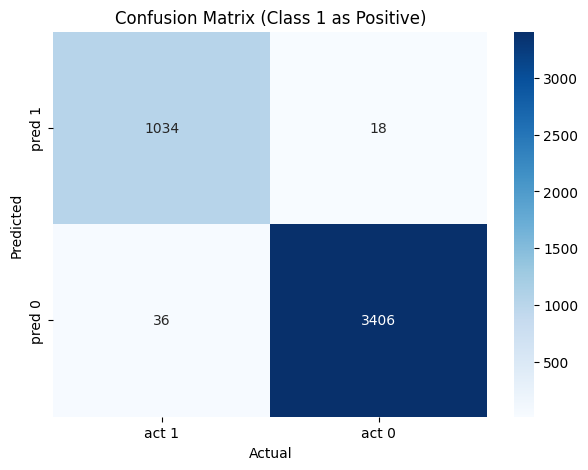

None


,0,1,accuracy,macro avg,weighted avg
precision,0.989541,0.982890,0.987984,0.986215,0.987957
recall,0.994743,0.966355,0.987984,0.980549,0.987984
f1-score,0.992135,0.974552,0.987984,0.983344,0.987949
support,3424.000000,1070.000000,0.987984,4494.000000,4494.000000


In [38]:
## 최적의 하이퍼파라미터로 재학습
# best_xgb = grid_search.best_estimator_
# best_xgb.fit(X_train, y_train)
best_xgb = grid_search


## 최적의 모델로 테스트 데이터에 대한 예측
y_pred_xgb = best_xgb.predict(X_test)


## 최종 혼동 행렬 및 분류 보고서 출력
print(custom_confusion_matrix(y_test, y_pred_xgb))
report = classification_report(y_test,
                                                              y_pred_xgb,
                                                              digits = 4,
                                                              output_dict=True)
pd.DataFrame(report)

In [39]:
## 클래스별 F1 Score
f1_score_class_0 = report['0']['f1-score']
f1_score_class_1 = report['1']['f1-score']


## 전체 평균 F1 Score
f1_score_macro_avg = report['macro avg']['f1-score']
f1_score_weighted_avg_xgb = report['weighted avg']['f1-score']


## 정확도
accuracy_xgb = report['accuracy']
accuracy_xgb

0.9879839786381842

## Light GBM

### Light Gradient Boosting Machine

In [40]:
# !pip install lightgbm
from lightgbm import LGBMClassifier

In [41]:
## LightGBM 기본 모델 설정
lgbm = LGBMClassifier(
                        objective = 'binary',  # 이진 분류
                        random_state = 123     # 랜덤 시드
                        # boosting_type = 'gbdt',  # 부스팅 유형
                        # num_leaves = 31,  # 하나의 트리가 가질 수 있는 최대 잎의 개수
                        # max_depth = -1,    # 트리의 최대 깊이 (-1은 제한 없음)
                        # learning_rate = 0.1,  # 학습률 (낮을수록 학습 정확도가 높아지나 오래 걸림..)
                        # n_estimators = 100,  # 생성할 트리의 개수
                        # min_child_samples = 20,  # 리프 노드의 최소 샘플 수
                        # subsample = 1.0,                   # 각 트리마다 사용할 훈련 데이터 샘플링 비율
                        # colsample_bytree = 1.0,  # 각 트리 구성 시 사용할 피처 비율
                        # reg_alpha = 0.0,                  # L1 정규화 강도
                        # reg_lambda = 0.0,              # L2 정규화 강도
                        # n_jobs = -1,                           #  사용할 CPU 코어 수 (-1은 모든 코어 사용)
                        # importance_type = 'split'  # 피처 중요도 계산 방식


)

lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 2497, number of negative: 7988
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 10485, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.238150 -> initscore=-1.162850
[LightGBM] [Info] Start training from score -1.162850


LGBMClassifier(objective='binary', random_state=123)

In [42]:
# from lightgbm import LGBMRegressor

# ## LGBM 회귀 모델
# # lgbm_model = LGBMRegressor(
#                                             n_estimators = 100,
#                                             learning_rate = 0.1,
#                                             random_state = 1234
#                                     )


### 1차 예측 결과

[[1021   14]
 [  49 3410]]


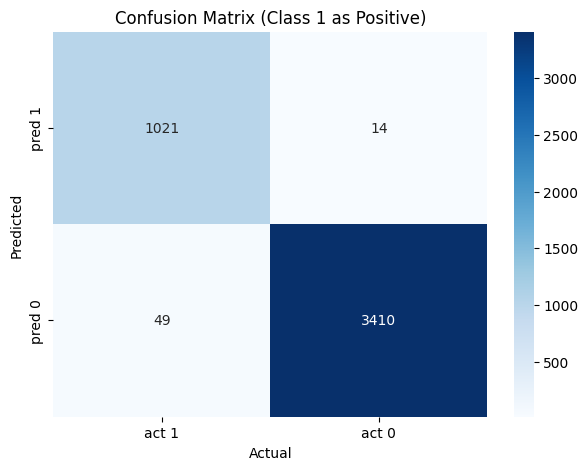

None


,0,1,accuracy,macro avg,weighted avg
precision,0.985834,0.986473,0.985981,0.986154,0.985986
recall,0.995911,0.954206,0.985981,0.975058,0.985981
f1-score,0.990847,0.970071,0.985981,0.980459,0.985900
support,3424.000000,1070.000000,0.985981,4494.000000,4494.000000


In [43]:
# 테스트 데이터에 대한 예측
y_pred_lgbm = lgbm.predict(X_test)

# 혼동 행렬 및 분류 보고서 출력
# y_pred_prob_lgbm = lgbm.predict_proba(X_test)

print(custom_confusion_matrix(y_test, y_pred_lgbm))
report = classification_report(y_test,
                                                              y_pred_lgbm,
                                                              digits = 4,
                                                              output_dict=True)
pd.DataFrame(report)

### 변수 중요도

In [44]:
## 변수 중요도 계산: 원래는 최적 파라미터를 찾은 다음에...
importance = pd.Series(lgbm.feature_importances_, index=X_train.columns)

# 중요도 순서대로 정렬
importance_sorted = importance.sort_values(ascending = False)
importance_sorted


,0
average_montly_hours,795
satisfaction_level,732
last_evaluation,548
number_project,319
time_spend_company,319
sales,146
salary,84
Work_accident,42
promotion_last_5years,15


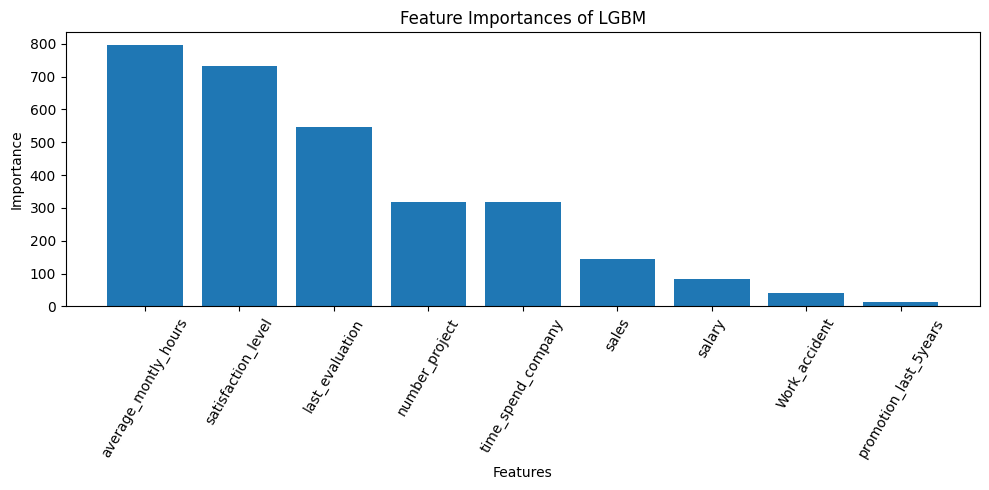

In [45]:
## 변수 중요도 시각화
plt.figure(figsize=(10, 5))
plt.title('Feature Importances of LGBM')
plt.bar(importance_sorted.index, importance_sorted.values)
plt.xticks(rotation=60)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

### 최적 파라미터 찾기

In [46]:
## 하이퍼파라미터 그리드 정의
param_grid = {
                      'n_estimators': [50, 100, 200],         # 약한 학습기의 개수
                      'num_leaves': [20, 30, 50],                # 한 트리에서 생성할 수 있는 leaf의 수
                    # 'learning_rate': [0.01, 0.1, 0.2],      # 학습률
                    # 'max_depth': [3, 5, 7],                        # 트리의 최대 깊이
                    # 'min_data_in_leaf': [10, 20, 30],    # 리프 노드의 최소 데이터 수
                    # 'feature_fraction': [0.6, 0.8, 1.0]     # 각 반복에서 사용할 특성의 비율
}

## GridSearchCV를 사용한 하이퍼파라미터 튜닝
grid_search = GridSearchCV(estimator=LGBMClassifier(),
                                                            param_grid = param_grid,
                                                            cv = 3,                 # 교차 검증 폴드 수
                                                            # refit = True    # 기본값
                                                            scoring = 'accuracy',   # 평가 지표: 정확도
                                                            n_jobs = -1,            # 병렬 처리
                                                            verbose = 1)           # 진행 상황 프린트
grid_search.fit(X_train, y_train)

## 최적의 하이퍼파라미터 출력
print(f"Best Hyperparameters: {grid_search.best_params_}")


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[LightGBM] [Info] Number of positive: 2497, number of negative: 7988
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 10485, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.238150 -> initscore=-1.162850
[LightGBM] [Info] Start training from score -1.162850
Best Hyperparameters: {'n_estimators': 200, 'num_leaves': 30}


[[1021   14]
 [  49 3410]]


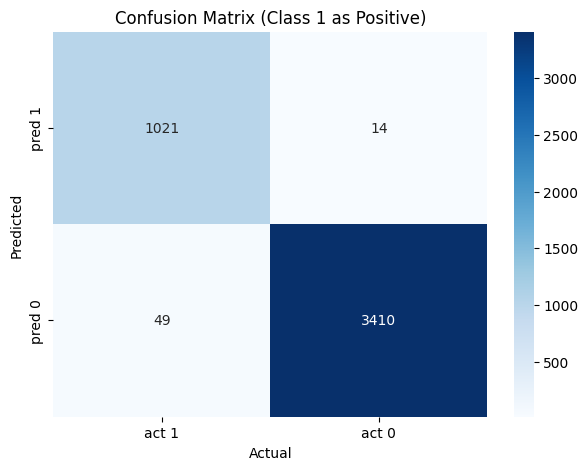

None


,0,1,accuracy,macro avg,weighted avg
precision,0.985834,0.986473,0.985981,0.986154,0.985986
recall,0.995911,0.954206,0.985981,0.975058,0.985981
f1-score,0.990847,0.970071,0.985981,0.980459,0.985900
support,3424.000000,1070.000000,0.985981,4494.000000,4494.000000


In [47]:
## 최적의 하이퍼파라미터로 재학습
# best_lgbm = grid_search.best_estimator_
# best_lgbm.fit(X_train, y_train)
best_lgbm = grid_search


## 최적의 모델로 테스트 데이터에 대한 예측
y_test_pred_best = best_lgbm.predict(X_test)


## 최종 혼동 행렬 및 분류 보고서 출력
print(custom_confusion_matrix(y_test, y_pred_lgbm))
report = classification_report(y_test,
                                                             y_pred_lgbm,
                                                             digits = 4,
                                                             output_dict=True)
pd.DataFrame(report)

In [48]:
## 클래스별 F1 Score
f1_score_class_0 = report['0']['f1-score']
f1_score_class_1 = report['1']['f1-score']


## 전체 평균 F1 Score
f1_score_macro_avg = report['macro avg']['f1-score']
f1_score_weighted_avg_lgbm = report['weighted avg']['f1-score']


## 정확도
accuracy_lgbm = report['accuracy']
accuracy_lgbm

0.985981308411215

## 비교

In [49]:
## 결과 비교
comparison_df = pd.DataFrame({
                                        'Model': ['Adaboost', 'GBM', 'XGB', 'LGBM'],
                                        'Accuracy': [accuracy_ada,
                                                              accuracy_gbm,
                                                              accuracy_xgb,
                                                              accuracy_lgbm],
                                        'f1-score': [f1_score_weighted_avg_ada,
                                                              f1_score_weighted_avg_gbm,
                                                              f1_score_weighted_avg_xgb,
                                                              f1_score_weighted_avg_lgbm]
                                  })

comparison_df

,Model,Accuracy,f1-score
0,Adaboost,0.965955,0.965735
1,GBM,0.979528,0.979400
2,XGB,0.987984,0.987949
3,LGBM,0.985981,0.985900


In [50]:
# EOS